# Aircraft Engine RUL Prediction

In [75]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler #to normalize data
import pywt
import os
# os.chdir("C:/Data/aircraft/")

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras import callbacks

In [76]:
# based on data wrangling python notebook
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/train_FD004.txt',delim_whitespace=True,names=input_file_column_names)
   
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/test_FD004.txt', delim_whitespace=True, names=input_file_column_names)

    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/RUL_FD004.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index

    
    return df_train, df_test, y_true

In [77]:
def wavelet_decomposition(data, wavelet='db1', level=1):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # For simplicity, we'll concatenate the coefficients into a single array
    return np.concatenate(coeffs)

def prepare_data_with_wavelet(drop_cols=True):
    df_train, df_test, y_true = prepare_data(drop_cols)
    
    # Apply wavelet decomposition on SensorMeasure2 of the training dataset
    df_train['SensorMeasure2'] = df_train['SensorMeasure2'].apply(wavelet_decomposition)
    df_train['SensorMeasure3'] = df_train['SensorMeasure3'].apply(wavelet_decomposition)
    df_train['SensorMeasure4'] = df_train['SensorMeasure4'].apply(wavelet_decomposition)
    df_train['SensorMeasure7'] = df_train['SensorMeasure7'].apply(wavelet_decomposition)
    df_train['SensorMeasure8'] = df_train['SensorMeasure8'].apply(wavelet_decomposition)
    df_train['SensorMeasure9'] = df_train['SensorMeasure9'].apply(wavelet_decomposition)
    df_train['SensorMeasure11'] = df_train['SensorMeasure11'].apply(wavelet_decomposition)
    df_train['SensorMeasure12'] = df_train['SensorMeasure12'].apply(wavelet_decomposition)
    df_train['SensorMeasure13'] = df_train['SensorMeasure13'].apply(wavelet_decomposition)
    df_train['SensorMeasure15'] = df_train['SensorMeasure15'].apply(wavelet_decomposition)
    df_train['SensorMeasure17'] = df_train['SensorMeasure17'].apply(wavelet_decomposition)
    df_train['SensorMeasure20'] = df_train['SensorMeasure20'].apply(wavelet_decomposition)
    df_train['SensorMeasure21'] = df_train['SensorMeasure21'].apply(wavelet_decomposition)
        # Apply wavelet decomposition on SensorMeasure2 of the training dataset
    df_test['SensorMeasure2'] = df_test['SensorMeasure2'].apply(wavelet_decomposition)
    df_test['SensorMeasure3'] = df_test['SensorMeasure3'].apply(wavelet_decomposition)
    df_test['SensorMeasure4'] = df_test['SensorMeasure4'].apply(wavelet_decomposition)
    df_test['SensorMeasure7'] = df_test['SensorMeasure7'].apply(wavelet_decomposition)
    df_test['SensorMeasure8'] = df_test['SensorMeasure8'].apply(wavelet_decomposition)
    df_test['SensorMeasure9'] = df_test['SensorMeasure9'].apply(wavelet_decomposition)
    df_test['SensorMeasure11'] = df_test['SensorMeasure11'].apply(wavelet_decomposition)
    df_test['SensorMeasure12'] = df_test['SensorMeasure12'].apply(wavelet_decomposition)
    df_test['SensorMeasure13'] = df_test['SensorMeasure13'].apply(wavelet_decomposition)
    df_test['SensorMeasure15'] = df_test['SensorMeasure15'].apply(wavelet_decomposition)
    df_test['SensorMeasure17'] = df_test['SensorMeasure17'].apply(wavelet_decomposition)
    df_test['SensorMeasure20'] = df_test['SensorMeasure20'].apply(wavelet_decomposition)
    df_test['SensorMeasure21'] = df_test['SensorMeasure21'].apply(wavelet_decomposition)
    # Similarly, you can apply it on the test dataset or other columns as needed
    
    return df_train, df_test, y_true

df_train, df_test, y_true = prepare_data_with_wavelet(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape



AxisError: Axis greater than data dimensions

## Model

### Data Preprocessing

To make sure that variance of features remain in the same range, it is important to scale the features. If a feature's variance is order of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not desirable.

In [78]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [79]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.fit_transform(df_test[feats])

min_max_scaler = MinMaxScaler(feature_range=(-1,1))



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [80]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [81]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [82]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [83]:
sequence_length = 50
mask_value = 0


Let's prepare data using above functions.

In [84]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(49048, 50, 15)


In [85]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(49048,)

In [86]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

C:\Users\elpaem\AppData\Local\Temp\ipykernel_21980\3243649304.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)


(248, 50, 15)


In [87]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(248,)

### LSTM Model

In [88]:
nb_features = x_train.shape[2]
nb_out = 1

In [89]:
nb_features

15

In [90]:
history = History()

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 100)           46400     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
 activation_2 (Activation)   (None, 1)                 0         
                                                                 
Total params: 126,901
Trainable params: 126,901
Non-tr

In [91]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
1380/1380 [==============================] - 51s 35ms/step - loss: 8856.2031 - mse: 8856.2031 - val_loss: 5146.0088 - val_mse: 5146.0088
Epoch 2/100
1380/1380 [==============================] - 47s 34ms/step - loss: 6463.3042 - mse: 6463.3042 - val_loss: 5146.8530 - val_mse: 5146.8530
Epoch 3/100
1380/1380 [==============================] - 47s 34ms/step - loss: 6465.6465 - mse: 6465.6465 - val_loss: 5143.9092 - val_mse: 5143.9092
Epoch 4/100
1380/1380 [==============================] - 52s 38ms/step - loss: 6461.2266 - mse: 6461.2266 - val_loss: 5140.8530 - val_mse: 5140.8530
Epoch 5/100
1380/1380 [==============================] - 55s 40ms/step - loss: 6467.4722 - mse: 6467.4722 - val_loss: 5135.5469 - val_mse: 5135.5469
Epoch 6/100
1380/1380 [==============================] - 55s 40ms/step - loss: 5431.6558 - mse: 5431.6558 - val_loss: 2477.0339 - val_mse: 2477.0339
Epoch 7/100
1380/1380 [==============================] - 56s 41ms/step - loss: 3122.3438 - mse: 3122.3438 

Let's plot the loss

In [92]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

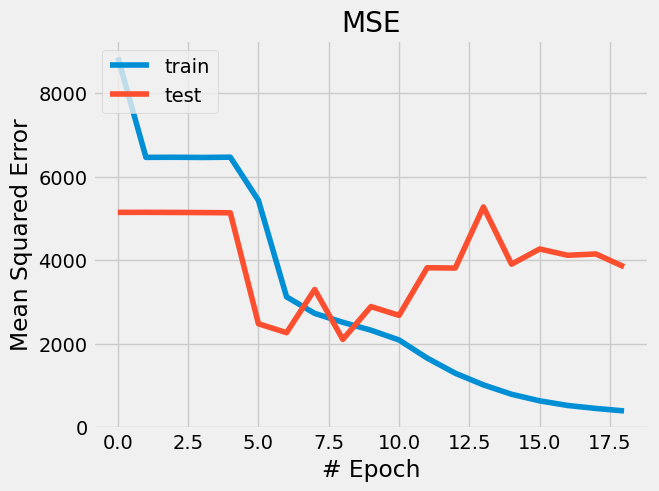

In [93]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Results on Train Set

In [94]:
scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

246/246 [==============================] - 14s 56ms/step - loss: 662.7747 - mse: 662.7747
MSE: 662.774658203125


### Results on Test Set

In [95]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print('MSE: {}'.format(scores_test[1]))

8/8 - 0s - loss: 2028.6534 - mse: 2028.6534 - 161ms/epoch - 20ms/step
MSE: 2028.6534423828125


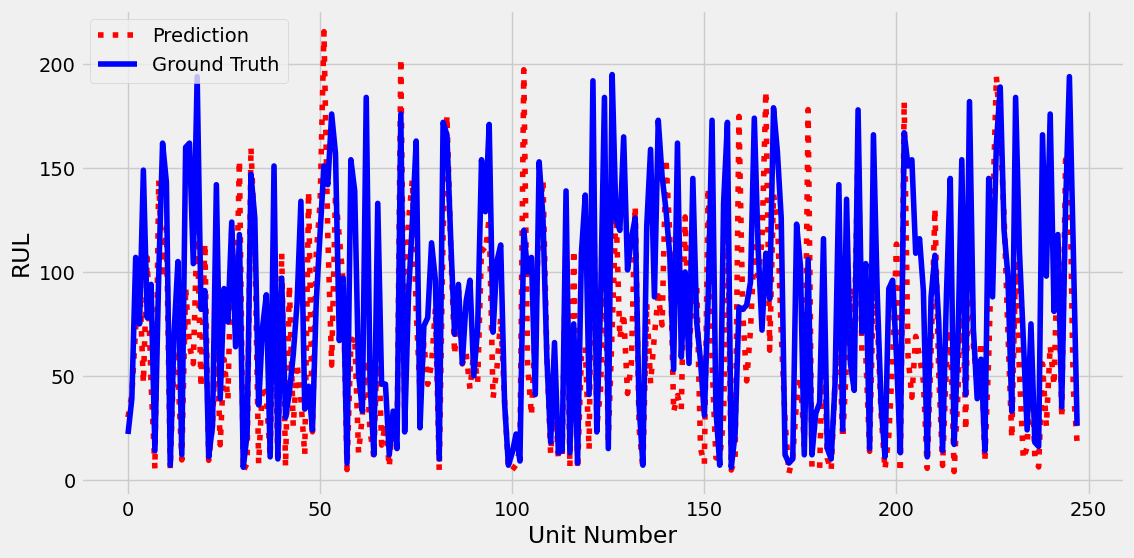

In [96]:
y_pred_test = model.predict(x_test, verbose=0)

np.savetxt('D:/timetofailure/preddwt.csv',y_pred_test, delimiter=',')
np.savetxt('D:/timetofailure/truevaldwt.csv',y_test, delimiter=',')
plt.figure(figsize=(12,6))
plt.plot(y_pred_test, color='red', label='Prediction',  linestyle='dotted')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()